# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Loading

In [2]:
data = pd.read_csv(f'../data/train.csv').values
X_full, y_full = data[:, :-1], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=0)

# PCA & Naive Bayes 

## PCA Gridsearch

In [3]:
scalers = [None, StandardScaler(), MinMaxScaler()]
classifiers = [GaussianNB(), MultinomialNB()]

def get_pca_param_grid(X_train):
    n_samples = X_train.shape[0]
    max_arpack = min(n_samples, X_train.shape[1]) - 1
    n_comp_list = list(range(1, max_arpack + 1))
    random_states = [0, 1, 2]

    param_grid = []
    for n_components in n_comp_list:
        for whiten in [True, False]:
            for svd_solver in ['auto', 'full', 'arpack', 'randomized']:
                if svd_solver == 'arpack' and n_components > max_arpack:
                    continue
                for random_state in random_states:
                    param_grid.append({
                        'pca__n_components': [n_components],
                        'pca__whiten': [whiten],
                        'pca__svd_solver': [svd_solver],
                        'pca__random_state': [random_state]
                    })
    return param_grid

def search_pca_pipeline(X_train, y_train, X_test, y_test, scoring, n_jobs, cv):
    results = []
    param_grid = get_pca_param_grid(X_train)
    for scaler in scalers:
        for clf in classifiers:
            steps = []
            if scaler is not None:
                steps.append(('scl', scaler))
            steps.append(('pca', PCA()))
            if isinstance(clf, MultinomialNB):
                steps.append(('minmax', MinMaxScaler()))
            steps.append(('clf', clf))

            pipeline = Pipeline(steps)
            scaler_name = scaler.__class__.__name__ if scaler is not None else 'None'

            try:
                grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, error_score='raise')
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                y_pred = best_model.predict(X_test)

                results.append({
                    'scaler': scaler_name,
                    'classifier': clf.__class__.__name__,
                    'best_params': grid.best_params_,
                    'best_cv_mean': grid.best_score_,
                    'best_cv_std': grid.cv_results_['std_test_score'][grid.best_index_],
                    'test_accuracy': accuracy_score(y_test, y_pred),
                })

            except Exception as e:
                print(f'Skipped scaler={scaler_name}, clf={clf.__class__.__name__}: {e}')
                continue
    return pd.DataFrame(results)

In [4]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
pca_results = search_pca_pipeline(X_train, y_train, X_test, y_test, scoring='accuracy', n_jobs=16, cv=cv)

In [5]:
pca_results

,scaler,classifier,best_params,best_cv_mean,best_cv_std,test_accuracy
0,None,GaussianNB,"{'pca__n_components': 6, 'pca__random_state': ...",0.786375,0.019543,0.8125
1,None,MultinomialNB,"{'pca__n_components': 18, 'pca__random_state':...",0.683188,0.027768,0.7500
2,StandardScaler,GaussianNB,"{'pca__n_components': 16, 'pca__random_state':...",0.717563,0.025935,0.7725
3,StandardScaler,MultinomialNB,"{'pca__n_components': 18, 'pca__random_state':...",0.667625,0.057537,0.5850
4,MinMaxScaler,GaussianNB,"{'pca__n_components': 17, 'pca__random_state':...",0.726063,0.027455,0.7375
5,MinMaxScaler,MultinomialNB,"{'pca__n_components': 19, 'pca__random_state':...",0.641125,0.049317,0.6875


## Selected PCA Explained Variance Ratio

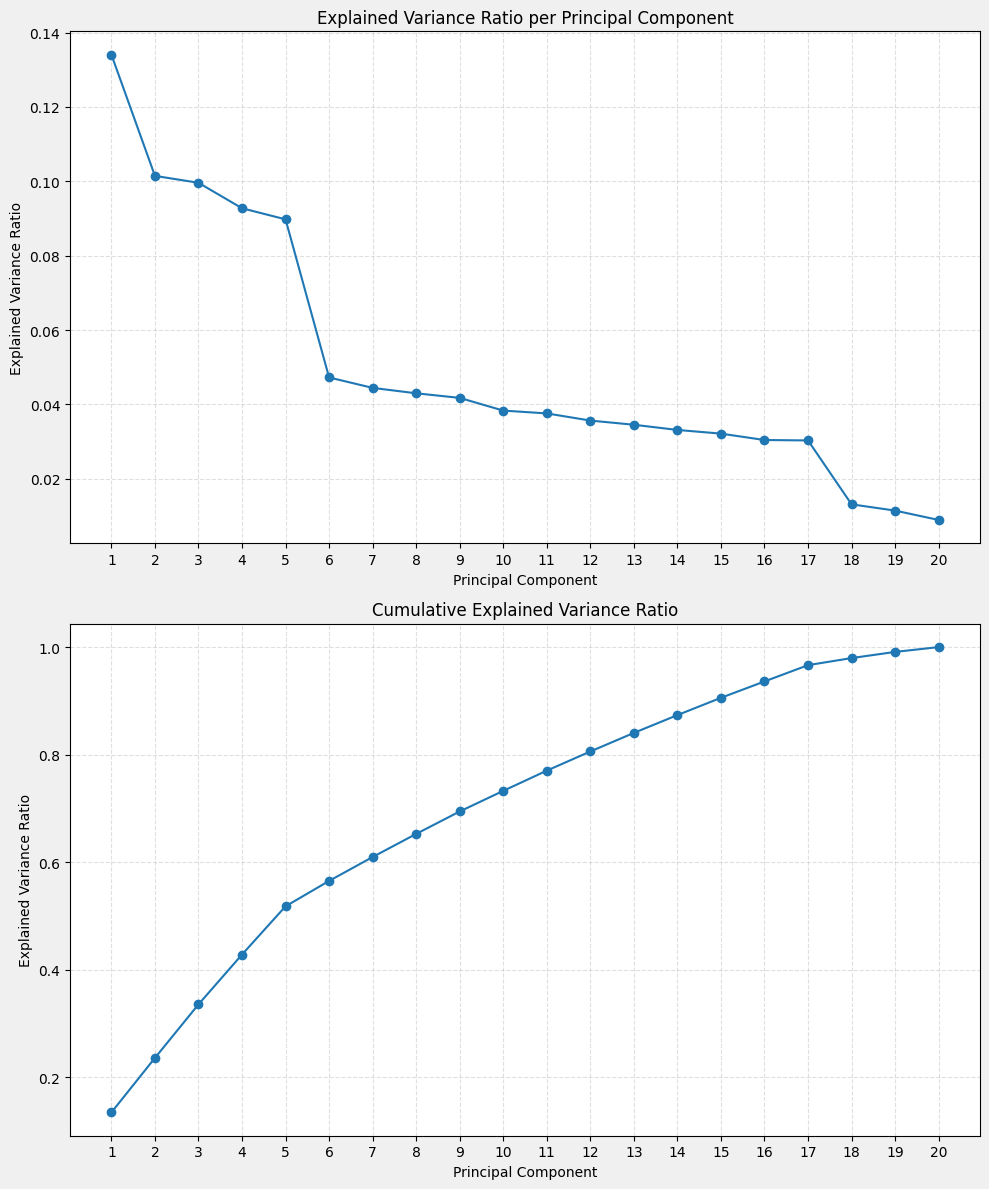

In [6]:
pca_params = {
    'n_components': 20,
    'svd_solver': 'auto',
    'whiten': True,
    'random_state': 0
}

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X_train)
pca = PCA(**pca_params)
pca.fit(X_scaled)

evr = pca.explained_variance_ratio_
cum_evr = np.cumsum(evr)
components = np.arange(1, pca_params['n_components'] + 1)

fig, ax = plt.subplots(2, 1, figsize=(10,12))
fig.patch.set_facecolor('#f0f0f0')

ax[0].set_facecolor('#ffffff')
ax[0].grid(True, linestyle='--', alpha=0.4)
ax[0].plot(components, evr, marker='o', linestyle='-')
ax[0].set_xticks(components)
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].set_title('Explained Variance Ratio per Principal Component')

ax[1].set_facecolor('#ffffff')
ax[1].grid(True, linestyle='--', alpha=0.4)
ax[1].plot(components, cum_evr, marker='o', linestyle='-')
ax[1].set_xticks(components)
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Explained Variance Ratio')
ax[1].set_title('Cumulative Explained Variance Ratio')

plt.tight_layout()
plt.show()

## Plot PCA 2D Projection

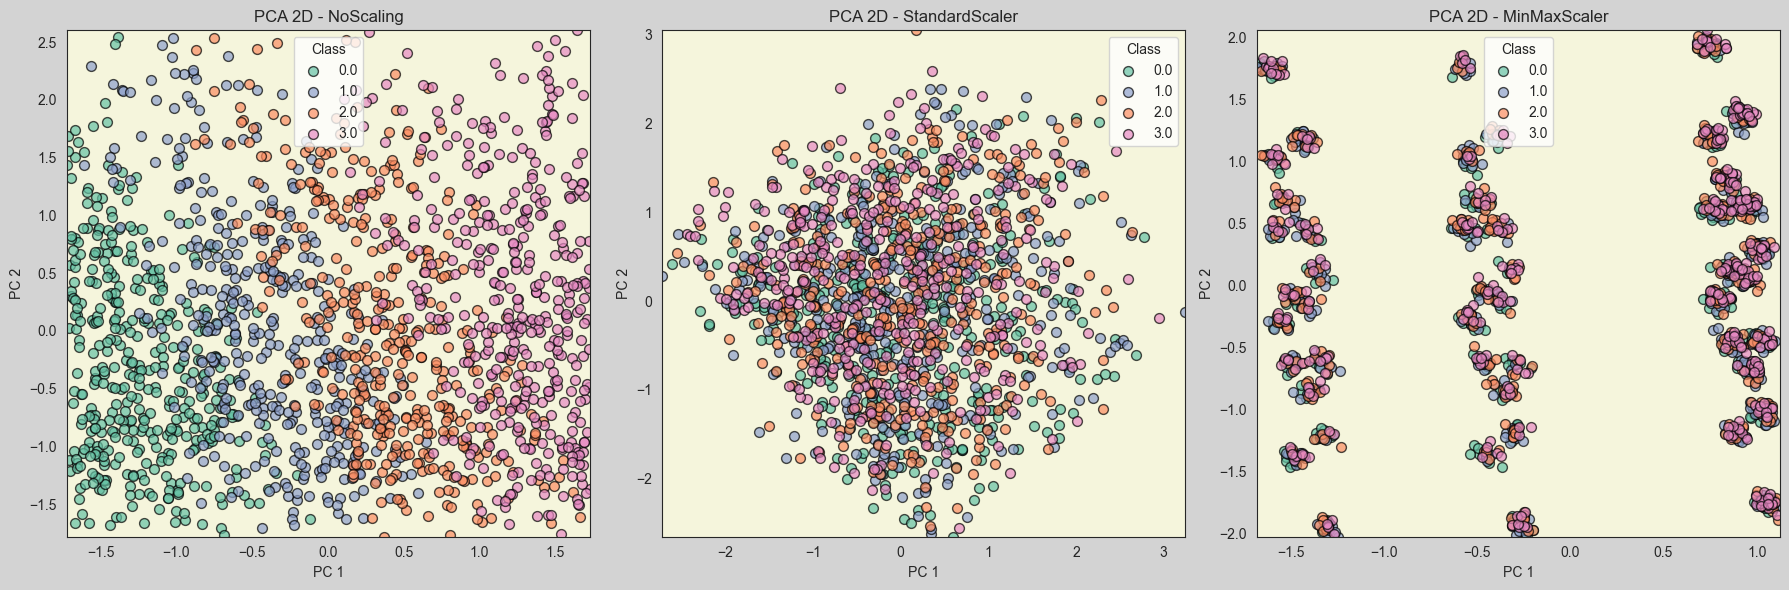

In [7]:
pca_params = {
    'n_components': 2,
    'svd_solver': 'auto',
    'whiten': True,
    'random_state': 0
}

scalers = {
    'NoScaling': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

colors = ['#66c2a5', '#8da0cb', '#fc8d62', '#e78ac3']

sns.set_style('white')
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False, sharey=False)
fig.patch.set_facecolor('lightgray')

for ax, (scaler_name, scaler) in zip(axes, scalers.items()):

    X_processed = scaler.fit_transform(X_train) if scaler else X_train
    pca = PCA(**pca_params)
    X_projected = pca.fit_transform(X_processed)

    X_min, X_max = X_projected[:, 0].min(), X_projected[:, 0].max()
    y_min, y_max = X_projected[:, 1].min(), X_projected[:, 1].max()

    classes = np.unique(y_train)
    for idx, cls in enumerate(classes):
        mask = (y_train == cls)
        ax.scatter(X_projected[mask, 0], X_projected[mask, 1], color=colors[idx], label=str(cls), alpha=0.7, edgecolor='k', s=50)

    ax.set_title(f'PCA 2D - {scaler_name}')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_facecolor('#f5f5dc')
    ax.grid(False)
    ax.set_xlim(X_min, X_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(title='Class')

plt.tight_layout()
plt.show()    



## Final Evaluation - Confusion Matrix

Test accuracy: 0.8250


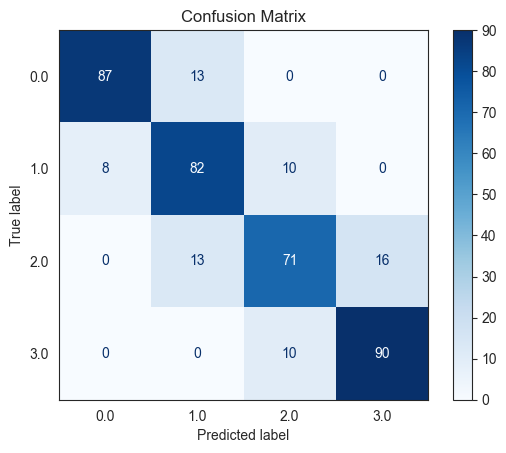

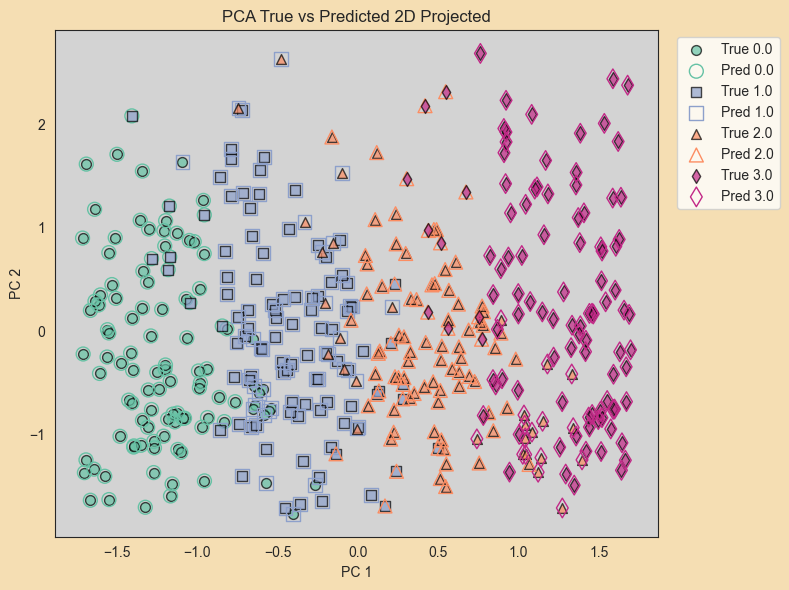

In [8]:
pca_params = {'n_components': 16,
              'svd_solver': 'auto',
              'whiten': True,
              'random_state': 0}
scaler = None
clf = GaussianNB()

steps = []
if scaler is not None:
    steps.append(('scaler', scaler))
steps.append(('pca', PCA(**pca_params)))
steps.append(('clf', clf))
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(f'Test accuracy: {accuracy_score(y_test, y_pred):.4f}')


disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(y_full), cmap='Blues')
disp.ax_.set_facecolor('lightgray')
disp.ax_.set_title('Confusion Matrix')
plt.show()

X_projected = pipe.named_steps['pca'].transform(pipe.named_steps['scaler'].transform(X_test)) if scaler else pipe.named_steps['pca'].transform(X_test)
classes = np.unique(y_test)
colors = ['#66c2a5', '#8da0cb', '#fc8d62', "#c22887"]
markers = ['o', 's', '^', 'd']

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#F5DEB3')
ax.set_facecolor('lightgray')

for i, cls in enumerate(classes):
    mask_true = (y_test == cls)
    ax.scatter(X_projected[mask_true, 0], X_projected[mask_true, 1], color=colors[i], marker=markers[i], label='True '+str(cls), alpha=0.7, edgecolor='k', s=50)

    mask_pred = (y_pred == cls)
    ax.scatter(X_projected[mask_pred, 0], X_projected[mask_pred, 1], facecolors='none', marker=markers[i], label='Pred '+str(cls), edgecolors=colors[i], s=100)

ax.set_title('PCA True vs Predicted 2D Projected')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(False)
plt.tight_layout()
plt.show()